In [15]:
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pipeline import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataset = Dataset(splits=(0.9, 0.1))
dataset.generate_datasplit()

C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["numVotes"].fillna(df["numVotes"].median(), inplace=True)  # We fill nan values with median of votes.
C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedi

In [8]:
unusable_cols = ["primaryTitle", "originalTitle", "index"]
train = dataset.train_df[dataset.train_df.columns.drop(unusable_cols)]
train_X, train_y = train[train.columns.drop('label')], train["label"]

test = dataset.test_df[dataset.test_df.columns.drop(unusable_cols)]
test_X, test_y = test[test.columns.drop('label')], test["label"]

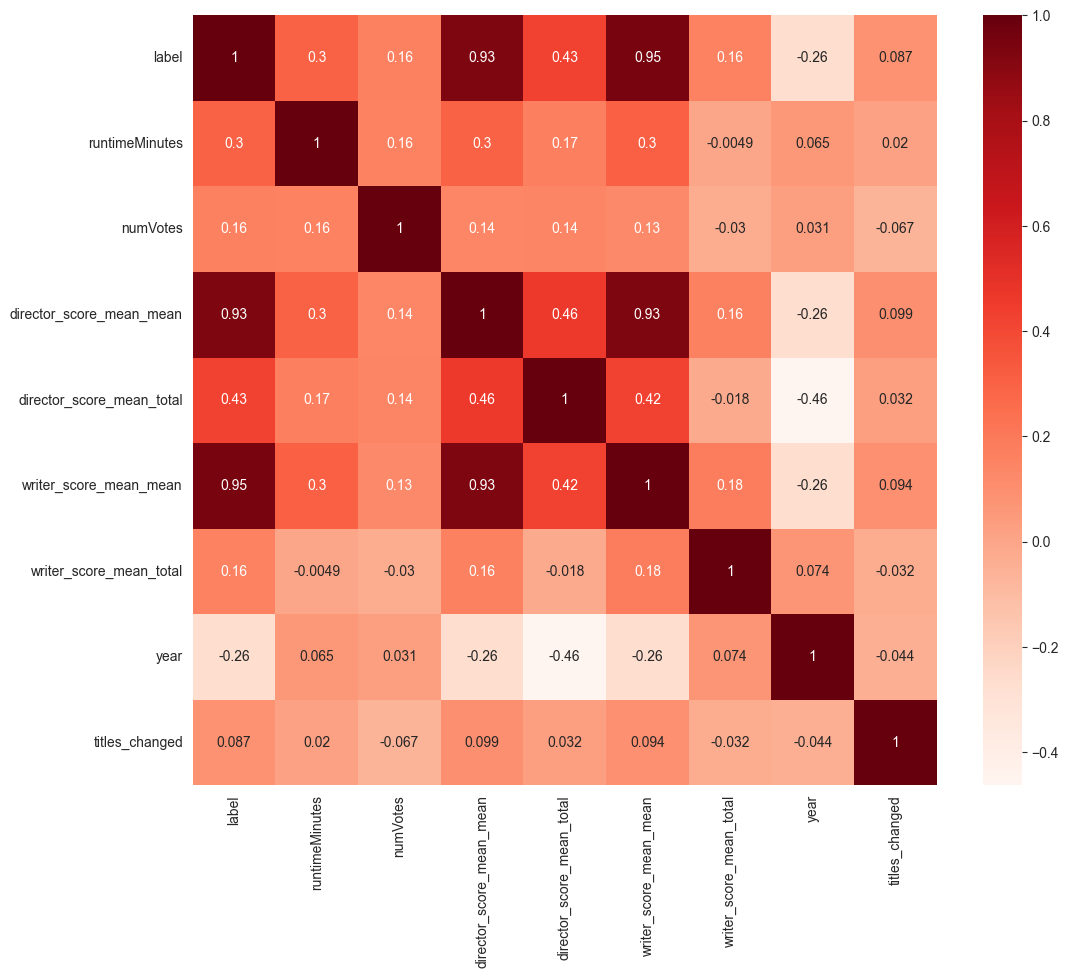

In [9]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
clf = RandomForestClassifier(max_depth=2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [50, 100, 200, 300]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model with GridSearchCV
grid_search.fit(train_X, train_y)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best parameters:", best_params)

y_pred = best_estimator.predict(test_X)

# Measure accuracy
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy:", accuracy)

# Perform K-fold cross-validation and print the mean accuracy
cv_accuracy = cross_val_score(best_estimator, train_X, train_y, cv=5, scoring='accuracy')
print("Cross-validated Accuracy:", cv_accuracy.mean())

Best parameters: {'max_depth': 8, 'n_estimators': 300}
Cross-validated Accuracy: 0.9866819957739672


In [16]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Overfitting a bit hehe 

## Prepare CSV files for kaggle

Assuming that the format will be index + prediction

In [22]:
validation = pd.read_csv("../data/validation_hidden.csv")
validation = dataset.process_dataframe(validation)
validation = validation.drop(unusable_cols, axis=1)

C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["numVotes"].fillna(df["numVotes"].median(), inplace=True)  # We fill nan values with median of votes.
C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedi

In [23]:
test = pd.read_csv("../data/test_hidden.csv")
test = dataset.process_dataframe(test)
test = test.drop(unusable_cols, axis=1)

C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["numVotes"].fillna(df["numVotes"].median(), inplace=True)  # We fill nan values with median of votes.
C:\Users\Oliver\PycharmProjects\BigDataProject_IMDB\pipeline\_dataset.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedi

In [24]:
validation["label"] = xgb_model.predict(validation)
test["label"] = xgb_model.predict(test)

validation["label"].astype(bool).to_csv("val_result.csv", index=False, header=None)
test["label"].astype(bool).to_csv("test_result.csv", index=False, header=None)

In [25]:
for file in ["val_result.csv", "test_result.csv"]:
    with open(file, 'r+') as f:
        f.seek(0,2)                    
        size=f.tell()               
        f.truncate(size-2)